In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model
"""from tensorflow.keras.preprocessing.image import ImageDataGenerator"""
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
import os
import shutil
import sys
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
from random import randint
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import random as rn
%matplotlib inline

In [2]:
import os
os.environ['PYTHONHASHEED']='0'

In [3]:
np.random.seed(1234)

In [4]:
rn.seed(4321)

In [5]:
tf.random.set_seed(1324)

In [6]:
'''from keras import backend as K
sess=tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)'''

'from keras import backend as K\nsess=tf.Session(graph=tf.get_default_graph(), config=session_conf)\nK.set_session(sess)'

In [7]:
#einfach um zu schauen, dass tensorflow das GPU identifizieren kann - wenn 1, dann wurde es identifiziert
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices)) # print out number of GPUs available
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [8]:
#Organize data into train, valid, test dirs
os.chdir(r"C:\Users\ammasi\Desktop\data\brain")
if os.path.isdir('train/0/') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0, 4):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 150)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 100)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')

In [9]:
train_path=r"C:\Users\ammasi\Desktop\data\brain\train"
valid_path=r"C:\Users\ammasi\Desktop\data\brain\valid"
test_path=r"C:\Users\ammasi\Desktop\data\brain\test"

In [10]:
'''train_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(class_mode='categorical',
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(class_mode='categorical',
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(class_mode='categorical',
    directory=test_path, target_size=(224,224), batch_size=10)'''

train_batches_mn = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(class_mode='categorical',
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches_mn = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(class_mode='categorical',
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches_mn = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(class_mode='categorical',
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 6023 images belonging to 4 classes.
Found 600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [11]:
assert train_batches_mn.n == 6023
assert valid_batches_mn.n == 600
assert test_batches_mn.n == 400
assert train_batches_mn.num_classes == valid_batches_mn.num_classes==test_batches_mn.num_classes==4

In [12]:
surface=tf.keras.applications.mobilenet.MobileNet()

In [13]:
surface.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [14]:
'''params = count_params(mobile)
assert params['non-trainable_params'] == 21888
assert params['trainable_params'] == 4231976'''

"params = count_params(mobile)\nassert params['non-trainable_params'] == 21888\nassert params['trainable_params'] == 4231976"

## Modify Model

In [15]:
x = surface.layers[-6].output

In [16]:
output = Dense(units=4, activation='softmax')(x)

In [17]:
model = Model(inputs=surface.input, outputs=output)

In [18]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [19]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

conv_dw_12_bn (BatchNormaliz (None, 7, 7, 512)         2048      
_________________________________________________________________
conv_dw_12_relu (ReLU)       (None, 7, 7, 512)         0         
_________________________________________________________________
conv_pw_12 (Conv2D)          (None, 7, 7, 1024)        524288    
_________________________________________________________________
conv_pw_12_bn (BatchNormaliz (None, 7, 7, 1024)        4096      
_________________________________________________________________
conv_pw_12_relu (ReLU)       (None, 7, 7, 1024)        0         
_________________________________________________________________
conv_dw_13 (DepthwiseConv2D) (None, 7, 7, 1024)        9216      
_________________________________________________________________
conv_dw_13_bn (BatchNormaliz (None, 7, 7, 1024)        4096      
_________________________________________________________________
conv_dw_13_relu (ReLU)       (None, 7, 7, 1024)        0         
__________

In [20]:
'''loss = tf.keras.losses.SparseCategoricalCrossentropy()
optim = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model.compile(loss=loss, optimizer=optim, metrics=metrics)'''

'loss = tf.keras.losses.SparseCategoricalCrossentropy()\noptim = keras.optimizers.Adam(lr=0.001)\nmetrics = ["accuracy"]\n\nmodel.compile(loss=loss, optimizer=optim, metrics=metrics)'

In [21]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [22]:
model.fit(x=train_batches_mn, validation_data=valid_batches_mn, epochs=10, verbose=2)

Epoch 1/10
603/603 - 22s - loss: 0.2727 - accuracy: 0.9024 - val_loss: 0.1368 - val_accuracy: 0.9550
Epoch 2/10
603/603 - 22s - loss: 0.0899 - accuracy: 0.9719 - val_loss: 0.0800 - val_accuracy: 0.9750
Epoch 3/10
603/603 - 18s - loss: 0.0512 - accuracy: 0.9844 - val_loss: 0.0974 - val_accuracy: 0.9667
Epoch 4/10
603/603 - 17s - loss: 0.0396 - accuracy: 0.9887 - val_loss: 0.0858 - val_accuracy: 0.9767
Epoch 5/10
603/603 - 17s - loss: 0.0274 - accuracy: 0.9927 - val_loss: 0.0605 - val_accuracy: 0.9867
Epoch 6/10
603/603 - 17s - loss: 0.0226 - accuracy: 0.9935 - val_loss: 0.1063 - val_accuracy: 0.9717
Epoch 7/10
603/603 - 20s - loss: 0.0311 - accuracy: 0.9899 - val_loss: 0.0876 - val_accuracy: 0.9750
Epoch 8/10
603/603 - 19s - loss: 0.0262 - accuracy: 0.9919 - val_loss: 0.1118 - val_accuracy: 0.9650
Epoch 9/10
603/603 - 18s - loss: 0.0163 - accuracy: 0.9952 - val_loss: 0.0529 - val_accuracy: 0.9850
Epoch 10/10
603/603 - 21s - loss: 0.0149 - accuracy: 0.9954 - val_loss: 0.0879 - val_accura

In [23]:
test_labels = test_batches_mn.classes

In [24]:
predictions = model.predict(x=test_batches_mn, steps=len(test_batches_mn), verbose=0)

In [25]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
test_batches_mn.class_indices

{'0': 0, '1': 1, '2': 2, '3': 3}

Confusion matrix, without normalization
[[100   0   0   0]
 [  0  99   1   0]
 [  0   0  98   2]
 [  0   0   3  97]]


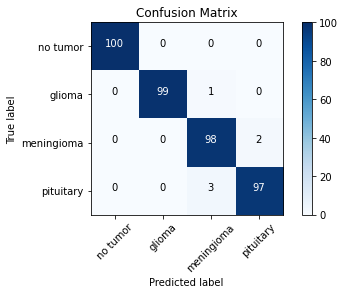

In [28]:
cm_plot_labels = ['no tumor','glioma','meningioma','pituitary']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [29]:
test_batches_mn.class_indices

{'0': 0, '1': 1, '2': 2, '3': 3}

## VVG16

In [30]:
train_batches_vgg16=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=["0", "1", "2", "3"], batch_size=10)
valid_batches_vgg16=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=["0", "1", "2", "3"], batch_size=10)
test_batches_vgg16=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=["0", "1", "2", "3"], batch_size=10, shuffle=False)

Found 6023 images belonging to 4 classes.
Found 600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [31]:
assert train_batches_vgg16.n == 6023
assert valid_batches_vgg16.n == 600
assert test_batches_vgg16.n == 400 
assert train_batches_vgg16.num_classes == valid_batches_vgg16.num_classes==test_batches_vgg16.num_classes==4


In [32]:
imgs, labels = next(train_batches_vgg16)

In [37]:
model=Sequential([
      Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same", input_shape=(224,224, 3)),
      MaxPool2D(pool_size=(2,2), strides=2),
      Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"),
      MaxPool2D(pool_size=(2,2), strides=2),
      Flatten(),
      Dense(units=4, activation ="softmax"),
                 ])

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 802820    
Total params: 822,212
Trainable params: 822,212
Non-trainable params: 0
________________________________________________

In [39]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [40]:
model.fit(x=train_batches_vgg16, validation_data=valid_batches_vgg16, epochs=10, verbose=2)

Epoch 1/10
603/603 - 17s - loss: 7.9931 - accuracy: 0.7617 - val_loss: 0.7040 - val_accuracy: 0.8550
Epoch 2/10
603/603 - 17s - loss: 0.1891 - accuracy: 0.9445 - val_loss: 0.7070 - val_accuracy: 0.8517
Epoch 3/10
603/603 - 17s - loss: 0.0463 - accuracy: 0.9832 - val_loss: 0.4098 - val_accuracy: 0.9050
Epoch 4/10
603/603 - 18s - loss: 0.0154 - accuracy: 0.9949 - val_loss: 0.4065 - val_accuracy: 0.9217
Epoch 5/10
603/603 - 22s - loss: 0.0215 - accuracy: 0.9919 - val_loss: 0.5278 - val_accuracy: 0.8900
Epoch 6/10
603/603 - 26s - loss: 0.0128 - accuracy: 0.9965 - val_loss: 0.4199 - val_accuracy: 0.9033
Epoch 7/10
603/603 - 21s - loss: 0.0567 - accuracy: 0.9852 - val_loss: 0.6945 - val_accuracy: 0.8500
Epoch 8/10
603/603 - 21s - loss: 0.0476 - accuracy: 0.9824 - val_loss: 0.4645 - val_accuracy: 0.8983
Epoch 9/10
603/603 - 21s - loss: 0.0307 - accuracy: 0.9910 - val_loss: 0.4615 - val_accuracy: 0.9100
Epoch 10/10
603/603 - 20s - loss: 0.0297 - accuracy: 0.9935 - val_loss: 0.4563 - val_accura

In [41]:
predictions=model.predict(x=test_batches_vgg16, verbose=0)

In [42]:
cm=confusion_matrix(y_true=test_batches_vgg16.classes, y_pred=np.argmax(predictions, axis=-1))

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html    

Confusion matrix, without normalization
[[98  1  1  0]
 [ 0 85 14  1]
 [ 2  9 83  6]
 [ 0  0  2 98]]


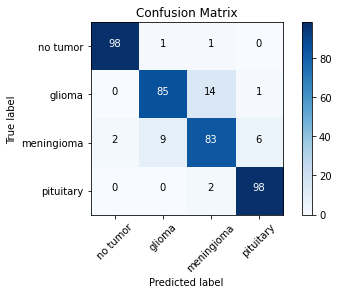

In [55]:
cm_plot_labels=['no tumor','glioma','meningioma','pituitary']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

## Resnet

In [56]:
train_batches_rn=ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), class_mode='categorical', batch_size=10)

valid_batches_rn=ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), class_mode='categorical', batch_size=10)

test_batches_rn=ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), class_mode='categorical', batch_size=10, shuffle=False)

Found 6023 images belonging to 4 classes.
Found 600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [57]:
assert train_batches_rn.n == 6023
assert valid_batches_rn.n == 600 
assert test_batches_rn.n == 400  
assert train_batches_rn.num_classes == valid_batches_rn.num_classes==test_batches_rn.num_classes==4

In [58]:
surface=tf.keras.applications.resnet.ResNet50()

In [59]:
surface.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [60]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [61]:
model.fit(x=train_batches_rn, validation_data=valid_batches_rn, epochs=10, verbose=2)

Epoch 1/10
603/603 - 18s - loss: 0.0213 - accuracy: 0.9960 - val_loss: 0.6683 - val_accuracy: 0.9000
Epoch 2/10
603/603 - 18s - loss: 0.0055 - accuracy: 0.9983 - val_loss: 0.4670 - val_accuracy: 0.9267
Epoch 3/10
603/603 - 18s - loss: 1.5510e-04 - accuracy: 1.0000 - val_loss: 0.4835 - val_accuracy: 0.9350
Epoch 4/10
603/603 - 18s - loss: 1.3002e-05 - accuracy: 1.0000 - val_loss: 0.4847 - val_accuracy: 0.9350
Epoch 5/10
603/603 - 21s - loss: 5.8860e-06 - accuracy: 1.0000 - val_loss: 0.4869 - val_accuracy: 0.9367
Epoch 6/10
603/603 - 19s - loss: 4.3911e-06 - accuracy: 1.0000 - val_loss: 0.4883 - val_accuracy: 0.9400
Epoch 7/10
603/603 - 23s - loss: 3.3105e-06 - accuracy: 1.0000 - val_loss: 0.4910 - val_accuracy: 0.9400
Epoch 8/10
603/603 - 29s - loss: 2.5224e-06 - accuracy: 1.0000 - val_loss: 0.4933 - val_accuracy: 0.9400
Epoch 9/10
603/603 - 27s - loss: 1.9293e-06 - accuracy: 1.0000 - val_loss: 0.4961 - val_accuracy: 0.9400
Epoch 10/10
603/603 - 28s - loss: 1.4751e-06 - accuracy: 1.0000

In [62]:
predictions=model.predict(x=test_batches_rn, verbose=0)

In [63]:
cm=confusion_matrix(y_true=test_batches_vgg16.classes, y_pred=np.argmax(predictions, axis=-1))

In [53]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html    

Confusion matrix, without normalization
[[98  2  0  0]
 [ 1 85 13  1]
 [ 1  8 86  5]
 [ 0  1  2 97]]


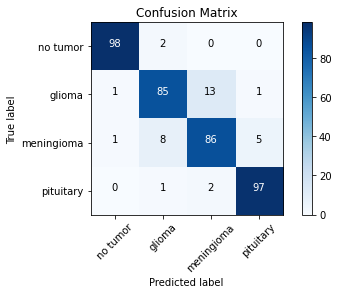

In [64]:
cm_plot_labels=['no tumor','glioma','meningioma','pituitary']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")